# Data Preprocessing and QC

In [10]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Loading Pillar Project Data

In [26]:
# pillar_condensed_df = pl.read_csv("../1_inputs/raw_inputs/pillar_data/pillar_data_condensed_051325_wREVEL.csv", schema_overrides={"Chrom": pl.String, 'aa_pos': pl.String, 'auth_reported_score': pl.String})
# pillar_condensed_df

pillar_clinvar_df = pl.read_csv("../1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_051325_wREVEL.csv", 
                                schema_overrides={"Chrom": pl.String, 'aa_pos': pl.String, 'auth_reported_score': pl.String})
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hg38_start").cast(pl.Int32).cast(pl.String).alias("nuc_loc")
)

print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
).with_columns(
    pl.concat_str([pl.col("Gene"),pl.col("aa_change")], separator="_").alias("gene_variant")
).sort("gene_variant", "gnomad_MAF", descending=[False,False])

print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])

display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Original pillar dataset shape: (1063392, 59)
Filtered missense/SNP pillar dataset shape: (128386, 60)
Number of unique gene variants: 61155
Number of unique genes: 33


ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,Flag,REVEL,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,Interval 4 name,Interval 4 range,Interval 4 MaveDB class,Interval 5 name,Interval 5 range,Interval 5 MaveDB class,Interval 6 name,Interval 6 range,Interval 6 MaveDB class,nuc_loc,aa_change,gene_variant
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.714,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp"""
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.714,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp"""
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.679,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly"""
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.2662""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.679,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly"""

## 1.2 Summary of Pillar Data

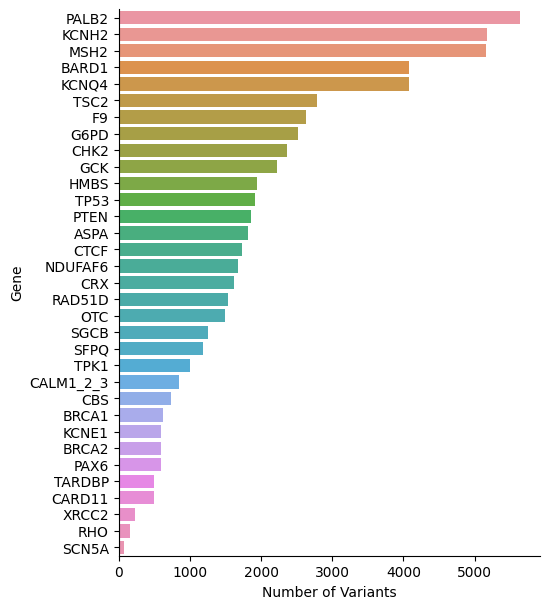

In [34]:
g = sns.catplot(data=pillar_clinvar_single_aa_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=6, aspect=.9)
# g.set_titles("Number of variants per gene Pillar dataset")

In [36]:
pillar_summary_df = pl.read_csv("../1_inputs/raw_inputs/pillar_data/summary_pp_df_051325_expanded.tsv", separator="\t", schema_overrides={"Chrom": pl.String, 'aa_pos': pl.String, 'auth_reported_score': pl.String})
pillar_summary_df

Dataset,Total_Variants,gnomAD,Pathogenic,Benign,Synonymous,Stop
str,i64,i64,i64,i64,i64,i64
"""ASPA_Grønbæk-Thygesen_2024_abu…",6151,365,67,6,0,915
"""ASPA_Grønbæk-Thygesen_2024_tox…",6148,365,67,6,0,915
"""BAP1_Waters_2024""",18108,1871,202,1060,1854,922
"""BARD1_unpublished""",8957,2006,129,980,1233,224
"""BRCA1_Adamovich_2022_Cisplatin""",1427,87,43,47,0,123
…,…,…,…,…,…,…
"""TPK1_Weile_2017""",3424,197,4,16,223,0
"""TSC2_rapgap_unpublished""",6016,678,87,322,629,849
"""TSC2_tuberin_unpublished""",3951,460,43,265,556,555


## 2. Loading VarChAMP data

In [38]:
def map_chr(num):
    if num == 23:
        return "X"
    elif num == 24:
        return "Y"
    elif num == 12920:
        return "MT"
    else:
        return str(num)
        

varchamp_seq_df = pl.read_csv("../1_inputs/VarChampSeqConfirmationResult.tsv", separator="\t")
varchamp_seq_df = varchamp_seq_df.with_columns(
    pl.concat_str([pl.col("symbol"),pl.col("aa_change")], separator="_").alias("gene_variant")
).with_columns(
    pl.col("spdi")
    .str.extract(r"NC_0*([0-9]+)", 1)
    .cast(pl.Int32)
    .alias("chr_num")
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .alias("Chrom")
).with_columns(
    pl.col("spdi").str.split(":").list.get(1).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).alias("alt_allele"),
)

varchamp_seq_df

# varchamp_seq_df["mutation_id_old"].unique()
# varchamp_seq_df.filter((pl.col("nuc_ref").str.len_chars()>1)|(pl.col("nuc_alt").str.len_chars()>1))
# varchamp_seq_df.unique(subset="gene_variant")

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,Chrom,nuc_loc,ref_allele,alt_allele
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32,str,str,str,str
"""GBA1""","""ENSG00000177628""",2,6,"""CCSBVarC000001""","""ALE0000584""","""NC_000001.11:155240033:C:G""","""160G>C""","""Val54Leu""","""RC4""","""RC4_Mut_GDEh1026""","""H01""","""GDEhDisVCh_40054""","""F12""","""2""","""RC4_Mut_GDDh1026""","""H01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Val54Leu""",1,"""1""","""155240033""","""C""","""G"""
"""GBA1""","""ENSG00000177628""",2,73,"""CCSBVarC000002""","""ALE00000002""","""NC_000001.11:155238225:G:A""","""670C>T""","""Leu224Phe""","""RC4""","""RC4_Mut_GDEh1026""","""E01""","""GDEhDisVCh_40054""","""C12""","""2""","""RC4_Mut_GDDh1026""","""E01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Leu224Phe""",1,"""1""","""155238225""","""G""","""A"""
"""GBA1""","""ENSG00000177628""",2,113,"""CCSBVarC000003""","""ALE00000003""","""NC_000001.11:155237453:C:T""","""887G>A""","""Arg296Gln""","""RC4""","""RC4_Mut_GDEh1026""","""F01""","""GDEhDisVCh_40054""","""D12""","""2""","""RC4_Mut_GDDh1026""","""F01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""7""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Arg296Gln""",1,"""1""","""155237453""","""C""","""T"""
"""GBA1""","""ENSG00000177628""",2,231,"""CCSBVarC000004""","""ALE00000004""","""NC_000001.11:155235252:A:G""","""1448T>C""","""Leu483Pro""","""RC4""","""RC4_Mut_GDEh1026""","""G01""","""GDEhDisVCh_40054""","""E12""","""2""","""RC4_Mut_GDDh1026""","""G01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Leu483Pro""",1,"""1""","""155235252""","""A""","""G"""
"""GBA1""","""ENSG00000177628""",2,213510,"""CCSBVarC003869""","""ALE00003869""","""NC_000001.11:155239934:G:A""","""259C>T""","""Arg87Trp""","""CEGS2""","""CegsMutGDEh1035""","""B03""","""GDEhDisVCh_40054""","""B02""","""2""","""CegsMutGDDh1035""","""B03""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Arg87Trp""",1,"""1""","""155239934""","""G""","""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""CTNNB1""","""ENSG00000168036""",100070227,212487,"""CCSBVarC007073""","""ALE00007071""","""NC_000003.12:41225785:A:G""","""860A>G""","""Asn287Ser""","""CEGS2""","""CegsMutGDEh1023""","""B07""","""GDEhDisVCh_40034""","""E09""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""CTNNB1_Asn287Ser""",3,"""3""","""41225785""","""A""","""G"""
"""TBX19""","""ENSG00000143178""",100070258,212488,"""CCSBVarC007074""","""ALE00007072""","""NC_000001.11:168291339:C:T""","""383C>T""","""Ser128Phe""","""CEGS2""","""CegsMutGDEh1043""","""A07""","""GDEhDisVCh_40046""","""B02""","""2""","""CegsMutGDDh1043""","""A07""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""7""",1,"""7""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""TBX19_Ser128Phe""",1,"""1""","""168291339""","""C""","""T"""
"""TBX19""","

In [45]:
# varchamp_consolid_seq_df = pl.read_csv("../1_inputs/VarChamp_Consolidated_allele_collection.tsv", separator="\t", infer_schema_length=10000)
# varchamp_consolid_seq_df

varchamp_consolid_seq_df = pl.read_csv("../1_inputs/varchamp_consolidated_alleles_clinvar_gnomad_dbnsfp_scores.tsv", separator="\t", infer_schema_length=10000)
varchamp_consolid_seq_df_sc = varchamp_consolid_seq_df.join(
    varchamp_seq_df,
    on="spdi",
    how="left"
)
# varchamp_consolid_seq_df_sc.write_csv("../3_outputs/varchamp_alleles_clinvar_gnomad_dbnsfp_sc.tsv", separator="\t")

## 3. Attempt to merge two datasets

### 3.1 Merge by gene_variant

In [48]:
pillar_varchamp_by_var_df = pillar_clinvar_single_aa_df.join(
    varchamp_seq_df,
    on="gene_variant" #["Chrom", "nuc_loc", "ref_allele", "alt_allele"]
)
display(pillar_varchamp_by_var_df.unique(subset="gene_variant"))

# pillar_varchamp_by_var_df.write_csv("../3_outputs/pillar_varchamp_overlapped_variants.tsv", separator="\t") #.unique(subset="spdi")

ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,…,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change_right,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,chr_num,Chrom_right,nuc_loc_right,ref_allele_right,alt_allele_right
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,…,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,i32,str,str,str,str
"""F9_Popp_2025_light_chain_var24…","""F9_Popp_2025_light_chain""","""F9""",3551.0,"""X""",1.0,null,1.39551113e8,1.39551113e8,"""G""","""A""",null,"""572""",null,null,"""191""","""R""","""H""","""c.572G>A""","""p.Arg191His""","""missense_variant""","""0.9560010972432093""",null,null,"""No""",0.000003,"""Pathogenic""","""reviewed by expert panel""","""Feb 09, 2024""","""aa""","""urn:mavedb:00001200-c-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""",null,null,…,"""ENSG00000101981""",52861,204360,"""CCSBVarC004379""","""ALE00004379""","""NC_000023.11:139551113:G:A""","""572G>A""","""Arg191His""","""CEGS2""","""CegsMutGDEh1028""","""C04""","""GDEhDisVCh_40052""","""D07""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""",23,"""X""","""139551113""","""G""","""A"""
"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,null,1.19092419e8,1.19092419e8,"""G""","""A""",null,"""667""",null,null,"""223""","""E""","""K""","""c.667G>A""","""p.Glu223Lys""","""missense_variant""","""0.0""",null,null,"""No""",0.000001,"""Conflicting classifications of…","""criteria provided, conflicting…","""Aug 08, 2019""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,null,null,…,"""ENSG00000256269""",2803,200944,"""CCSBVarC005171""","""ALE00005171""","""NC_000011.10:119092419:G:A""","""667G>A""","""Glu223Lys""","""CEGS2""","""CegsMutGDEh1037""","""G11""","""GDEhDisVCh_40054""","""H03""","""2""","""CegsMutGDDh1037""","""G11""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",11,"""11""","""119092419""","""G""","""A"""
"""MSH2_Jia_2021_var17994""","""MSH2_Jia_2021""","""MSH2""",7325.0,"""2""",1.0,null,4.7466718e7,4.7466718e7,"""G""","""C""","""NM_000251.2""","""1571""",null,null,"""524.0""","""R""","""P""","""c.1571G>C""","""p.Arg524Pro""","""missense_variant""","""3.33401200346854""",null,null,"""No""",null,"""Likely pathogenic""","""reviewed by expert panel""","""Jun 21, 2019""","""aa""","""urn:mavedb:00000050-a-1""","""ENST00000233146.7""","""NM_000251.2""","""immortalized human cells""","""Cell Viability""","""Drug Resistance""","""Mismatch Repair""",…,"""ENSG00000095002""",7918,202671,"""CCSBVarC003011""","""ALE00003011""","""NC_000002.12:47466718:G:C""","""1571G>C""","""Arg524Pro""","""CEGS2""","""CegsMutGDEh1047""","""C02""","""GDEhDisVC

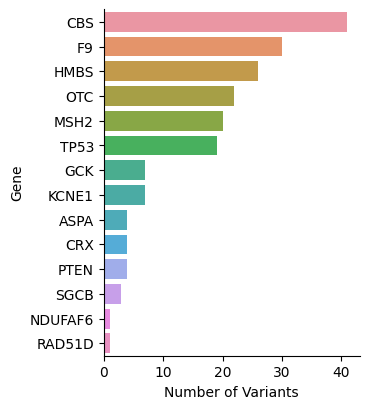

In [58]:
g = sns.catplot(data=pillar_varchamp_by_var_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)

In [60]:
# varchamp_seq_df.filter(pl.col("symbol")=="RHO")

### 3.2 Merge by genomic locations

In [55]:
pillar_varchamp_by_gen_loc_df = pillar_clinvar_single_aa_df.join(
    varchamp_seq_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_vc"
)
display(pillar_varchamp_by_gen_loc_df.unique(subset="gene_variant"))
pillar_varchamp_by_gen_loc_df.filter(pl.col("gene_variant")==pl.col("gene_variant_vc")).unique(subset="gene_variant")

ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,…,aa_change,gene_variant,symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change_vc,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant_vc,chr_num
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32
"""HMBS_van_Loggerenberg_2023_ery…","""HMBS_van_Loggerenberg_2023_ery…","""HMBS""",4982.0,"""11""",1.0,null,1.19090213e8,1.19090213e8,"""G""","""A""",null,"""446""",null,null,"""149""","""R""","""Q""","""c.446G>A""","""p.Arg149Gln""","""missense_variant""","""0.0016450579999999""",null,null,"""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Oct 08, 1999""","""aa""","""urn:mavedb:00000108-a-2""","""ENST00000652429.1""","""NM_000190.4""","""yeast""","""Cell viability""",null,null,…,"""Arg149Gln""","""HMBS_Arg149Gln""","""HMBS""","""ENSG00000256269""",2803,200930,"""CCSBVarC005163""","""ALE00005163""","""NC_000011.10:119090213:G:A""","""446G>A""","""Arg149Gln""","""CEGS2""","""CegsMutGDEh1037""","""B04""","""GDEhDisVCh_40054""","""E03""","""2""","""CegsMutGDDh1037""","""B04""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""HMBS_Arg149Gln""",11
"""SGCB_Li_2023_var426045""","""SGCB_Li_2023""","""SGCB""",10806.0,"""4""",-1.0,null,5.2029808e7,5.2029808e7,"""A""","""T""",null,"""299""",null,null,"""100""","""M""","""K""","""c.299T>A""","""p.Met100Lys""","""missense_variant""","""-2.02""",null,"""Non-Functional""","""No""",6.1962e-7,"""Conflicting classifications of…","""criteria provided, conflicting…","""Aug 28, 2023""","""aa""","""urn:mavedb:00000659-a-1""","""ENST00000381431.10""","""NM_000232.5""","""immortalized human cells""","""Reporter""","""Fluorescence""","""surface expression""",…,"""Met100Lys""","""SGCB_Met100Lys""","""SGCB""","""ENSG00000163069""",100010885,225816,"""CCSBVarC006987""","""ALE00006985""","""NC_000004.12:52029808:A:T""","""299T>A""","""Met100Lys""","""CEGS2""","""CegsMutGDEh1043""","""E06""","""GDEhDisVCh_40045""","""D01""","""1""","""CegsMutGDDh1043""","""E06""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""SGCB_Met100Lys""",4
"""OTC_Lo_2023_var105027""","""OTC_Lo_2023""","""OTC""",8512.0,"""X""",1.0,null,3.8411941e7,3.8411941e7,"""T""","""C""","""NM_000531.6""","""947""",null,null,"""316.0""","""F""","""S""","""c.947T>C""","""p.Phe316Ser""","""missense_variant""","""0.0035930190368981""",null,"""Amorphic""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""-""","""aa""","""urn:mavedb:00000112-a-1""","""ENST00000039007.5""","""NM_000531.6""","""yeast""","""Cell Viability""","""Cell Survival""","""Overall function""",…,"""Phe316Ser""","""OTC_Phe316Ser""","""OTC""","""ENSG00000036473""",71569,35642,"""CCSBVarC002762""","""ALE000027

ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,…,aa_change,gene_variant,symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change_vc,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant_vc,chr_num
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32
"""F9_Popp_2025_light_chain_var24…","""F9_Popp_2025_light_chain""","""F9""",3551.0,"""X""",1.0,null,1.39541127e8,1.39541127e8,"""A""","""G""",null,"""329""",null,null,"""110""","""D""","""G""","""c.329A>G""","""p.Asp110Gly""","""missense_variant""","""1.0519859626998802""",null,null,"""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Apr 01, 1989""","""aa""","""urn:mavedb:00001200-c-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""",null,null,…,"""Asp110Gly""","""F9_Asp110Gly""","""F9""","""ENSG00000101981""",52861,204356,"""CCSBVarC004377""","""ALE00004377""","""NC_000023.11:139541127:A:G""","""329A>G""","""Asp110Gly""","""CEGS2""","""CegsMutGDEh1027""","""D10""","""GDEhDisVCh_40052""","""B07""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""F9_Asp110Gly""",23
"""TP53_Fortuno_2021_Kato_meta_va…","""TP53_Fortuno_2021_Kato_meta""","""TP53""",11998.0,"""17""",-1.0,null,7.670678e6,7.670678e6,"""A""","""G""","""NM_000546.5""","""1031""",null,null,"""344""","""L""","""P""","""c.1031T>C""","""p.Leu344Pro""","""missense_variant""","""9.25""",null,null,"""No""",6.1955e-7,"""Likely pathogenic""","""reviewed by expert panel""","""Aug 05, 2024""","""aa""",null,"""ENST00000269305.9""","""NM_000546.5""",null,null,null,null,…,"""Leu344Pro""","""TP53_Leu344Pro""","""TP53""","""ENSG00000141510""",3774,214911,"""CCSBVarC004879""","""ALE00004879""","""NC_000017.11:7670678:A:G""","""1031T>C""","""Leu344Pro""","""CEGS2""","""CegsMutGDEh1021""","""C10""","""GDEhDisVCh_40053""","""G07""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""TP53_Leu344Pro""",17
"""SGCB_Li_2023_var426045""","""SGCB_Li_2023""","""SGCB""",10806.0,"""4""",-1.0,null,5.2029808e7,5.2029808e7,"""A""","""T""",null,"""299""",null,null,"""100""","""M""","""K""","""c.299T>A""","""p.Met100Lys""","""missense_variant""","""-2.02""",null,"""Non-Functional""","""No""",6.1962e-7,"""Conflicting classifications of…","""criteria provided, conflicting…","""Aug 28, 2023""","""aa""","""urn:mavedb:00000659-a-1""","""ENST00000381431.10""","""NM_000232.5""","""immortalized human cells""","""Reporter""","""Fluorescence""","""surface expression""",…,"""Met100Lys""","""SGCB_Met100Lys""","""SGCB""","""ENSG00000163069""",100010885,225816,"""CCSBVarC006987""","""ALE00006985""","""NC_000004.12:52029808:A:T""","""299T>A""","""Met100Lys""","""CEG

In [63]:
# varchamp_consolid_seq_df_sc.filter(
#     pl.col("symbol").is_in(pillar_clinvar_single_aa_df["Gene"].unique())
# ).write_csv("../3_outputs/varchamp_pillar_genes.tsv", separator="\t") #.unique(subset="spdi")